In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import os
import numpy as np
import pandas as pd
import random as rnd
import tensorflow as tf

rnd.seed(34)

In [2]:
data = pd.read_csv("questions.csv")
N = len(data)
print('Number of question pairs: ', N)
data.head()

Number of question pairs:  404351


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
N_train = 300000
N_test = 10240
data_train = data[:N_train]
data_test = data[N_train:N_train + N_test]
print("Train set:", len(data_train), "Test set:", len(data_test))
del (data)

Train set: 300000 Test set: 10240


In [4]:
td_index = data_train['is_duplicate'] == 1
td_index = [i for i, x in enumerate(td_index) if x]
print('Number of duplicate questions: ', len(td_index))
print('Indexes of first ten duplicate questions:', td_index[:10])

Number of duplicate questions:  111486
Indexes of first ten duplicate questions: [5, 7, 11, 12, 13, 15, 16, 18, 20, 29]


In [5]:
print(data_train['question1'][5])
print(data_train['question2'][5])
print('is_duplicate: ', data_train['is_duplicate'][5])

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?
is_duplicate:  1


In [6]:
Q1_train = np.array(data_train['question1'][td_index])
Q2_train = np.array(data_train['question2'][td_index])

Q1_test = np.array(data_test['question1'])
Q2_test = np.array(data_test['question2'])
y_test  = np.array(data_test['is_duplicate'])

print('TRAINING QUESTIONS:\n')
print('Question 1: ', Q1_train[0])
print('Question 2: ', Q2_train[0], '\n')
print('Question 1: ', Q1_train[5])
print('Question 2: ', Q2_train[5], '\n')

print('TESTING QUESTIONS:\n')
print('Question 1: ', Q1_test[0])
print('Question 2: ', Q2_test[0], '\n')
print('is_duplicate =', y_test[0], '\n')

TRAINING QUESTIONS:

Question 1:  Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
Question 2:  I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me? 

Question 1:  What would a Trump presidency mean for current international master’s students on an F1 visa?
Question 2:  How will a Trump presidency affect the students presently in US or planning to study in US? 

TESTING QUESTIONS:

Question 1:  How do I prepare for interviews for cse?
Question 2:  What is the best way to prepare for cse? 

is_duplicate = 0 



In [7]:
cut_off = int(len(Q1_train) * 0.8)
train_Q1, train_Q2 = Q1_train[:cut_off], Q2_train[:cut_off]
val_Q1, val_Q2 = Q1_train[cut_off:], Q2_train[cut_off:]
print('Number of duplicate questions: ', len(Q1_train))
print("The length of the training set is:  ", len(train_Q1))
print("The length of the validation set is: ", len(val_Q1))

Number of duplicate questions:  111486
The length of the training set is:   89188
The length of the validation set is:  22298


In [8]:
tf.random.set_seed(0)
text_vectorization = tf.keras.layers.TextVectorization(output_mode='int',split='whitespace', standardize='strip_punctuation')
text_vectorization.adapt(np.concatenate((Q1_train,Q2_train)))

In [9]:
print(f'Vocabulary size: {text_vectorization.vocabulary_size()}')

Vocabulary size: 36224


In [10]:
print('first question in the train set:\n')
print(Q1_train[0], '\n') 
print('encoded version:')
print(text_vectorization(Q1_train[0]),'\n')

print('first question in the test set:\n')
print(Q1_test[0], '\n')
print('encoded version:')
print(text_vectorization(Q1_test[0]) )

first question in the train set:

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me? 

encoded version:
tf.Tensor(
[ 6984     6   178    10  8988  2442 35393   761    13  6636 28205    31
    28   483    45    98], shape=(16,), dtype=int64) 

first question in the test set:

How do I prepare for interviews for cse? 

encoded version:
tf.Tensor([    4     8     6   160    17  2079    17 11775], shape=(8,), dtype=int64)


In [11]:
def Siamese(text_vectorizer, vocab_size=36224, d_feature=128):
    """Returns a Siamese model.

    Args:
        text_vectorizer (TextVectorization): TextVectorization instance, already adapted to your training data.
        vocab_size (int, optional): Length of the vocabulary. Defaults to 36224, which is the vocabulary size for your case.
        d_model (int, optional): Depth of the model. Defaults to 128.
        
    Returns:
        tf.model.Model: A Siamese model. 
    
    """
    branch = tf.keras.models.Sequential(name='sequential')
    branch.add(text_vectorizer)
    branch.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=d_feature, name='embedding'))
    branch.add(tf.keras.layers.LSTM(units=d_feature, return_sequences=True, name='LSTM'))
    branch.add(tf.keras.layers.GlobalAveragePooling1D(name='mean'))
    branch.add(tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name='out'))
    input1 = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='input_1')
    input2 = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='input_2')
    branch1 = branch(input1)
    branch2 = branch(input2)
    conc = tf.keras.layers.Concatenate(axis=1, name='conc_1_2')([branch1, branch2]) 
    
    return tf.keras.models.Model(inputs=[input1, input2], outputs=conc, name="SiameseModel")

In [12]:
model = Siamese(text_vectorization, vocab_size=text_vectorization.vocabulary_size())
model.build(input_shape=None)
model.summary()

Model: "SiameseModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_2             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128)       │  4,768,256 │ input_1[0][0],    │
│ (Sequential)        │                   │            │ input_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conc_1_2            │ (None, 256)       │          0 │ sequential[0][0], │
│ (Concatenate)       │                   │            │ sequential[1][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,768,256 (18.19 MB)

 Trainable params: 4,768,256 (18.19 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.get_layer(name='sequential').summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 128)      │     4,636,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM (LSTM)                     │ (None, None, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mean (GlobalAveragePooling1D)   │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Lambda)                    │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,768,256 (18.19 MB)

 Trainable params: 4,768,256 (18.19 MB)

 Non-trainable params: 0 (0.00 B)

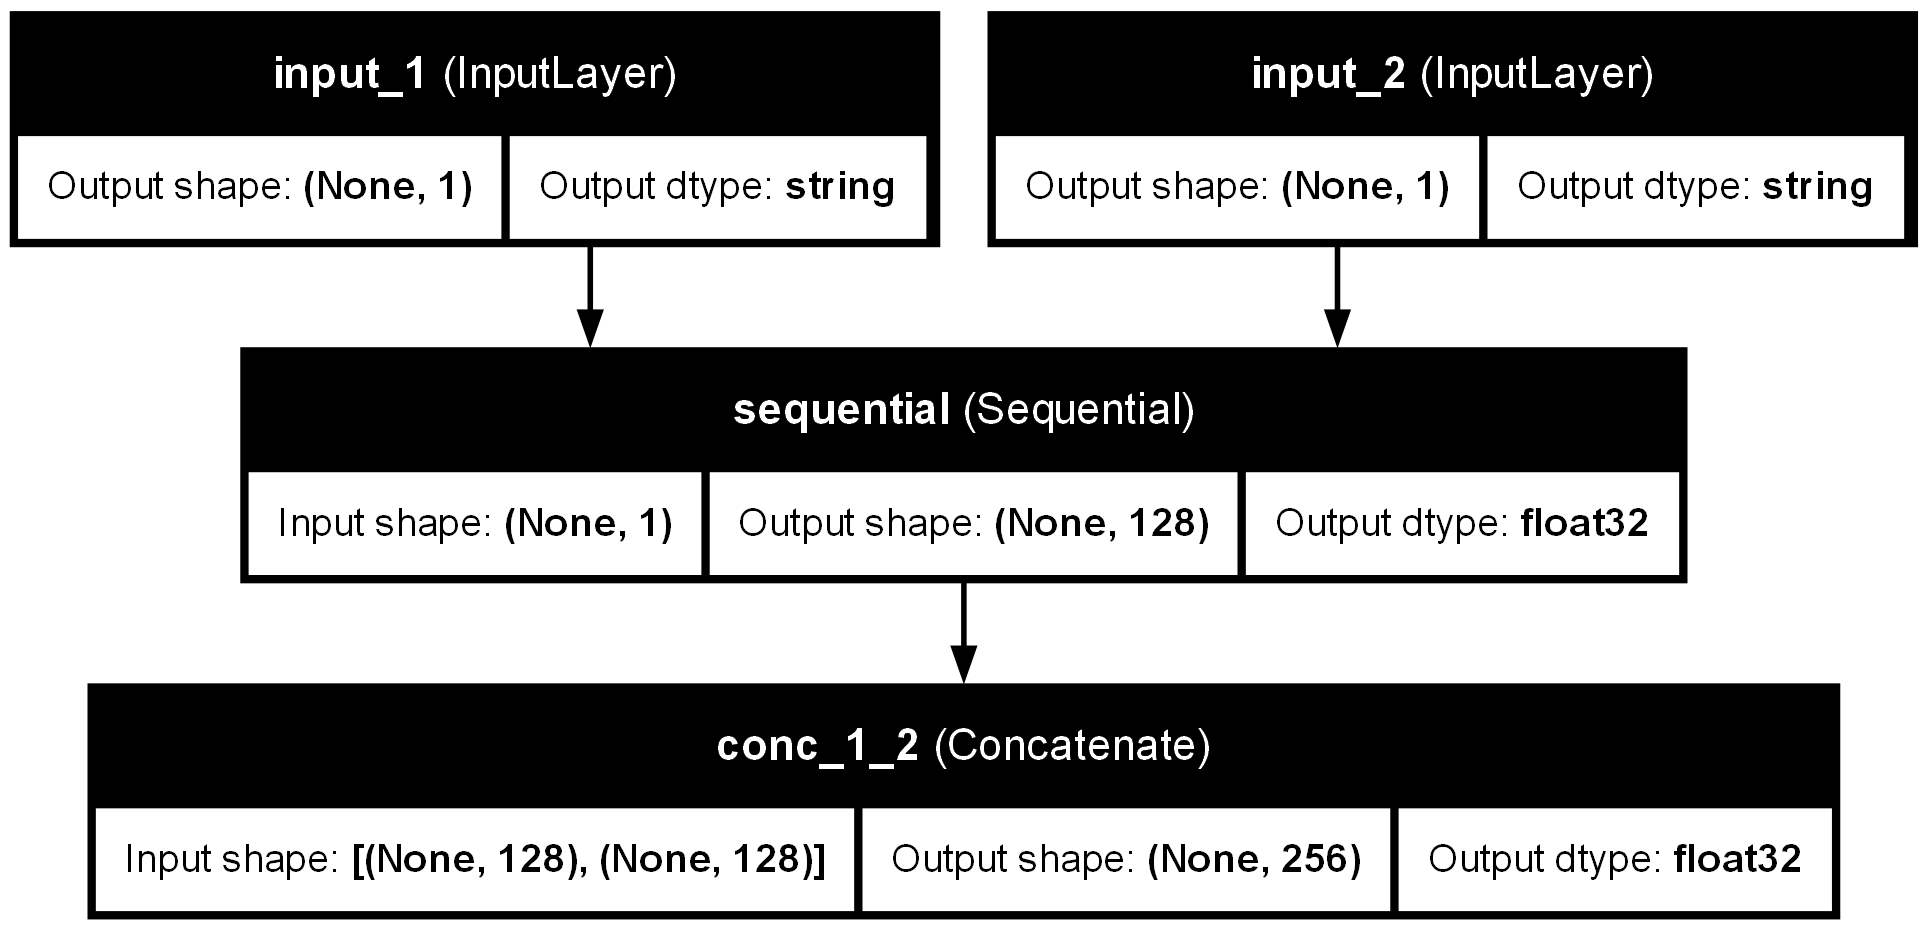

In [14]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True)

# install graphviz software and pydot module

In [15]:
def TripletLossFn(v1, v2,  margin=0.25):
    """Custom Loss function.

    Args:
        v1 (numpy.ndarray or Tensor): Array with dimension (batch_size, model_dimension) associated to Q1.
        v2 (numpy.ndarray or Tensor): Array with dimension (batch_size, model_dimension) associated to Q2.
        margin (float, optional): Desired margin. Defaults to 0.25.

    Returns:
        triplet_loss (numpy.ndarray or Tensor)
    """
    scores = tf.linalg.matmul(tf.math.l2_normalize(v2,axis=1),tf.math.l2_normalize(v1,axis=1), transpose_b=True)
    batch_size = tf.cast(tf.shape(v1)[0], scores.dtype) 
    positive = tf.linalg.diag_part(scores)
    negative_zero_on_duplicate = scores - tf.linalg.diag(positive)
    mean_negative = tf.math.reduce_sum(negative_zero_on_duplicate, axis=1, keepdims=True) / (batch_size - 1)
    mask_exclude_positives = tf.cast(
        (tf.eye(batch_size) > 0) | (negative_zero_on_duplicate > tf.linalg.diag_part(scores)[:, None]), 
        scores.dtype
        )
    negative_without_positive = negative_zero_on_duplicate - mask_exclude_positives * 2.0
    closest_negative = tf.math.reduce_max(negative_without_positive, axis=1, keepdims=True)
    triplet_loss1 = tf.maximum(closest_negative - positive + margin, 0)
    triplet_loss2 = tf.maximum(mean_negative - positive + margin, 0)
    triplet_loss = tf.math.reduce_sum(triplet_loss1 + triplet_loss2)

    return triplet_loss

In [16]:
v1 = np.array([[0.26726124, 0.53452248, 0.80178373],[0.5178918 , 0.57543534, 0.63297887]])
v2 = np.array([[ 0.26726124,  0.53452248,  0.80178373],[-0.5178918 , -0.57543534, -0.63297887]])
print("Triplet Loss:", TripletLossFn(v1,v2).numpy())

Triplet Loss: 5.110523069185324


In [17]:
def TripletLoss(labels, out, margin=0.25):
    _, out_size = out.shape
    v1 = out[:,:int(out_size/2)]
    v2 = out[:,int(out_size/2):]
    return TripletLossFn(v1, v2, margin=margin)

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices(((train_Q1, train_Q2),tf.constant([1]*len(train_Q1))))
val_dataset = tf.data.Dataset.from_tensor_slices(((val_Q1, val_Q2),tf.constant([1]*len(val_Q1))))

In [19]:
def train_model(Siamese, TripletLoss, text_vectorizer, train_dataset, val_dataset, d_feature=128, lr=0.01, train_steps=5):
    """Training the Siamese Model

    Args:
        Siamese (function): Function that returns the Siamese model.
        TripletLoss (function): Function that defines the TripletLoss loss function.
        text_vectorizer: trained instance of `TextVecotrization` 
        train_dataset (tf.data.Dataset): Training dataset
        val_dataset (tf.data.Dataset): Validation dataset
        d_feature (int, optional) = size of the encoding. Defaults to 128.
        lr (float, optional): learning rate for optimizer. Defaults to 0.01
        train_steps (int): number of epochs
        
    Returns:
        tf.keras.Model
    """
    model = Siamese(text_vectorizer,
                    vocab_size = len(text_vectorizer.get_vocabulary()),
                    d_feature = d_feature)
    model.compile(loss=TripletLoss,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr)
            )
    model.fit(train_dataset,
              epochs=train_steps,
              validation_data=val_dataset)

    return model

In [22]:
train_steps = 2
batch_size = 256
train_generator = train_dataset.shuffle(len(train_Q1),
                                        seed=7, 
                                        reshuffle_each_iteration=True).batch(batch_size=batch_size)
val_generator = val_dataset.shuffle(len(val_Q1), 
                                   seed=7,
                                   reshuffle_each_iteration=True).batch(batch_size=batch_size)
model = train_model(Siamese, TripletLoss,text_vectorization, 
                                            train_generator, 
                                            val_generator, 
                                            train_steps=train_steps,)

Epoch 1/2
349/349 ━━━━━━━━━━━━━━━━━━━━ 31s 84ms/step - loss: 17685.7266 - val_loss: 4151.1562
Epoch 2/2
349/349 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - loss: 2887.3416 - val_loss: 2864.5225


In [23]:
model.summary()

Model: "SiameseModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_2             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128)       │  4,768,256 │ input_1[0][0],    │
│ (Sequential)        │                   │            │ input_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conc_1_2            │ (None, 256)       │          0 │ sequential[0][0], │
│ (Concatenate)       │                   │            │ sequential[1][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,304,770 (54.57 MB)

 Trainable params: 4,768,256 (18.19 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,536,514 (36.38 MB)

In [24]:
def classify(test_Q1, test_Q2, y_test, threshold, model, batch_size=64, verbose=True):
    """Function to test the accuracy of the model.

    Args:
        test_Q1 (numpy.ndarray): Array of Q1 questions. Each element of the array would be a string.
        test_Q2 (numpy.ndarray): Array of Q2 questions. Each element of the array would be a string.
        y_test (numpy.ndarray): Array of actual target.
        threshold (float): Desired threshold
        model (tensorflow.Keras.Model): The Siamese model.
        batch_size (int, optional): Size of the batches. Defaults to 64.

    Returns:
        float: Accuracy of the model
        numpy.array: confusion matrix
    """
    y_pred = []
    test_gen = tf.data.Dataset.from_tensor_slices(((test_Q1, test_Q2), None)).batch(batch_size=batch_size)

    pred = model.predict(test_gen)
    _, n_feat = pred.shape
    v1 = pred[:, :n_feat // 2]
    v2 = pred[:, n_feat // 2:]
    d = tf.reduce_sum(tf.multiply(v1, v2), axis=1)

    y_pred = tf.cast(d > threshold, tf.float64)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y_pred, y_test), tf.float64))

    cm = tf.math.confusion_matrix(y_test, y_pred)
    
    return accuracy, cm

In [30]:
accuracy, cm = classify(Q1_test,Q2_test, y_test, 0.7, model,  batch_size = 512) 
print("Accuracy", accuracy.numpy())
print(f"Confusion matrix:\n{cm.numpy()}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Accuracy 0.73115234375
Confusion matrix:
[[4291 2091]
 [ 662 3196]]


In [26]:
def predict(question1, question2, threshold, model, verbose=False):
    """Function for predicting if two questions are duplicates.

    Args:
        question1 (str): First question.
        question2 (str): Second question.
        threshold (float): Desired threshold.
        model (tensorflow.keras.Model): The Siamese model.
        verbose (bool, optional): If the results should be printed out. Defaults to False.

    Returns:
        bool: True if the questions are duplicates, False otherwise.
    """
    generator = tf.data.Dataset.from_tensor_slices((([question1], [question2]), None)).batch(batch_size=1)
    v1v2 = model.predict(generator)
    v1 = v1v2[:, :128]
    v2 = v1v2[:, 128:]
    d = tf.reduce_sum(tf.multiply(v1, v2), axis=1)
    res = d > threshold

    if verbose:
        print("Q1  = ", question1, "\nQ2  = ", question2)
        print("d   = ", d.numpy())
        print("res = ", res.numpy())

    return res.numpy()

In [27]:
question1 = "When will I see you?"
question2 = "When can I see you again?"
predict(question1 , question2, 0.7, model, verbose = True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
Q1  =  When will I see you? 
Q2  =  When can I see you again?
d   =  [0.87983525]
res =  [ True]


array([ True])

In [28]:
question1 = "Do they enjoy eating the dessert?"
question2 = "Do they like hiking in the desert?"
predict(question1 , question2, 0.7, model, verbose=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Q1  =  Do they enjoy eating the dessert? 
Q2  =  Do they like hiking in the desert?
d   =  [0.43475294]
res =  [False]


array([False])